<a href="https://colab.research.google.com/github/sajidcsecu/polarImage/blob/main/RHFMReconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Necessary Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from skimage.metrics import structural_similarity as ssim

# 2. Cartesian and Polar RHFM Reconstruction

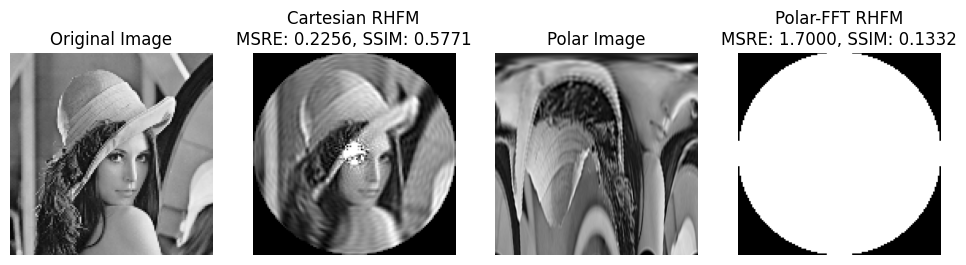

In [20]:
class RHFMReconstructor:
    def __init__(self, image, order=10):
        self.image = image
        self.min_intensity = np.min(self.image)
        self.max_intensity = np.max(self.image)
        self.image -= self.min_intensity
        self.order = order
        self.cartesian_coeffs = None
        self.polar_fft_coeffs = None
        h, w = self.image.shape
        self.center_x, self.center_y = w // 2, h // 2
        xq = (2* np.arange(w) - w +1 ) / w
        yp = (h - 1 - 2 * np.arange(h)) / h
        x, y = np.meshgrid(xq, yp, indexing='xy')
        self.r = np.sqrt(np.square(x) + np.square(y))
        self.theta= np.arctan2(y, x)
        self.basis = self.basis_function(self.order, self.order, self.r, self.theta)

    def radial_factors(self, order, r):
        p = np.arange(order+1)
        p = p[:, np.newaxis, np.newaxis]
        rp = np.ones((order+1, *r.shape), dtype=r.dtype)
        rp[1::2, ...] = np.sqrt(2) * np.sin(np.pi * (p[1::2, ...] + 1) * r)
        rp[2::2, ...] = np.sqrt(2) * np.cos(np.pi * p[2::2, ...] * r)
        r1 = np.zeros_like(r)
        np.reciprocal(r, where=r!=0., out=r1)
        rp *= np.sqrt(r1)
        rp[:, r >= 1] = 0.
        return rp

    def exponential_factors(self, repetition, theta):
        q = np.arange(-repetition, repetition + 1)[:, np.newaxis, np.newaxis]
        return np.exp(1j * q * theta)

    def basis_function(self, order, repetition, r, theta):
        ru = self.radial_factors(order, r)[:, np.newaxis, ...]
        ev = self.exponential_factors(repetition, theta)[np.newaxis, ...]
        return ru * ev

    def compute_rhfm_cartesian(self):
        """Compute Cartesian RHFM coefficients"""
        self.cartesian_coeffs = np.sum(self.basis.conj() * self.image, axis=(-1, -2)) * 2 / (np.pi * self.image.size)
        return self.cartesian_coeffs

    def cartesian_to_polar(self,scaling_factor=4):
        height, width = image.shape
        center_x, center_y = width // 2, height // 2

        # Define output polar image size
        polar_height = int(scaling_factor * height)  # Radial resolution
        polar_width = int(scaling_factor * width)    # Angular resolution
        #polar_image = np.zeros((polar_height, polar_width), dtype=image.dtype)

        # Create grids for radius (r) and angle (theta)
        r = np.linspace(0, 1, polar_height)  # Normalized radius (0 to 1)
        theta = np.linspace(0, 2 * np.pi, polar_width)  # Full 360-degree range

        # Create meshgrid in polar coordinates
        t, r = np.meshgrid(theta, r, indexing='xy')

        # Convert polar coordinates to Cartesian coordinates
        x = (r * (width / 2) * np.cos(t)) + center_x
        y = -(r * (height / 2) * np.sin(t)) + center_y+1

        # Convert to float32 for OpenCV remapping
        x = x.astype(np.float32)
        y = y.astype(np.float32)

        # Use OpenCV remap with correct interpolation
        polar_image = cv2.remap(self.image, x, y, interpolation=cv2.INTER_CUBIC)

        return polar_image

    def compute_rhfm_polar_fft(self):
        """Compute Polar-based RHFM coefficients using FFT with improved normalization."""
        polar_image = self.cartesian_to_polar()  # Use bicubic interpolation for better quality

        # Normalize polar image to [0,1]
        polar_image = (polar_image - np.min(polar_image)) / (np.max(polar_image) - np.min(polar_image) + 1e-8)

        n = np.arange(self.order + 1)
        m = np.arange(-self.order, self.order + 1)
        self.polar_fft_coeffs = np.zeros((len(n), len(m)), dtype="complex")

        polar_height, polar_width = polar_image.shape
        r = np.linspace(0, 1, polar_height)
        theta = np.linspace(0, 2 * np.pi, polar_width)
        theta_grid, r_grid = np.meshgrid(theta, r, indexing='xy')

        # Apply radial weighting to balance the transformation
        g_polar_image = np.sqrt(1 / 2) * np.sqrt(r_grid) * polar_image

        # Compute FFT and apply new normalization method
        ft_polar_image = np.fft.fft2(g_polar_image)
        ft_polar_image = np.fft.fftshift(ft_polar_image)
        # ft_polar_image /= np.max(np.abs(ft_polar_image))

        height, width = ft_polar_image.shape
        center = height // 2

        n_grid, m_grid = np.meshgrid(n, m, indexing='ij')

        center_n_plus = np.clip(center + n_grid, 0, height - 1)
        center_n_minus = np.clip(center - n_grid, 0, height - 1)
        center_m = np.clip(center + m_grid, 0, width - 1)

        mask_n_zero = (n_grid == 0)
        self.polar_fft_coeffs[mask_n_zero] = np.sqrt(2) * ft_polar_image[center, center_m[mask_n_zero]]

        mask_n_even = (n_grid % 2 == 0) & (n_grid != 0)
        self.polar_fft_coeffs[mask_n_even] = (
            ft_polar_image[center_n_plus[mask_n_even], center_m[mask_n_even]] +
            ft_polar_image[center_n_minus[mask_n_even], center_m[mask_n_even]]
        )

        mask_n_odd = (n_grid % 2 != 0)
        self.polar_fft_coeffs[mask_n_odd] = (
            (ft_polar_image[center_n_plus[mask_n_odd], center_m[mask_n_odd]] -
            ft_polar_image[center_n_minus[mask_n_odd], center_m[mask_n_odd]]) * 1j
        )

        return self.polar_fft_coeffs


    def reconstruct_image(self, coefficients):
        """Reconstruct an image using RHFM coefficients"""
        coefficients = coefficients[..., np.newaxis, np.newaxis]  # Align with basis dimensions
        reconstructed_image = np.abs(np.sum(coefficients * self.basis, axis=(0, 1)))  # Sum over appropriate axes
        reconstructed_image = np.clip(reconstructed_image, 0, self.max_intensity - self.min_intensity).astype(self.image.dtype)
        reconstructed_image = reconstructed_image + self.min_intensity
        return reconstructed_image

    def evaluate_reconstruction(self, reconstructed):
        """Evaluate reconstruction using MSRE and SSIM"""
        original = self.image.astype(np.float32)
        reconstructed = reconstructed.astype(np.float32)

        msre = np.sum((original - reconstructed) ** 2) / (np.sum(original ** 2) + 1e-8)  # Added epsilon
        ssim_value = ssim(original, reconstructed, data_range=original.max() - original.min())
        return msre, ssim_value

    def run(self):
        """Main pipeline to compute, reconstruct, and evaluate RHFM methods"""
        self.compute_rhfm_cartesian()
        self.compute_rhfm_polar_fft()

        polar_image = self.cartesian_to_polar()

        cartesian_reconstructed = self.reconstruct_image(self.cartesian_coeffs)
        polar_fft_reconstructed = self.reconstruct_image(self.polar_fft_coeffs)

        mse_cartesian, ssim_cartesian = self.evaluate_reconstruction(cartesian_reconstructed)
        mse_polar_fft, ssim_polar_fft = self.evaluate_reconstruction(polar_fft_reconstructed)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 4, 1)
        plt.imshow(self.image, cmap='gray')
        plt.title('Original Image')
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(cartesian_reconstructed, cmap='gray')
        plt.title(f'Cartesian RHFM\nMSRE: {mse_cartesian:.4f}, SSIM: {ssim_cartesian:.4f}')
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(polar_image, cmap='gray')
        plt.title(f'Polar Image')
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.imshow(polar_fft_reconstructed, cmap='gray')
        plt.title(f'Polar-FFT RHFM\nMSRE: {mse_polar_fft:.4f}, SSIM: {ssim_polar_fft:.4f}')
        plt.axis("off")

        plt.show()

# Usage
if __name__ == "__main__":
    image = cv2.imread("/content/lena.png", cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    reconstructor = RHFMReconstructor(image,40)
    reconstructor.run()
